In [50]:
import numpy as np
from matplotlib import pyplot as plt
from matplotlib.ticker import AutoMinorLocator
from mayavi import mlab
from numba import jit
from tvtk.tools import visual
from scipy import interpolate
import math
from numpy import unravel_index
import pickle
from datalib import Data
aberration=False
from mayavi import mlab
from scipy.interpolate import griddata

In [81]:
T = 80
omega = 2*np.pi/T
c = 3e10

R = 2
r_em = 8.0

N1 = 800
N2 = N1
N3 = N1

w = np.ceil(c/omega/1e3/1e6)
print (w)
xa = np.linspace(-w,w,N1)
ya = np.linspace(-w,w,N2)
za = np.linspace(-w,w,N3)
center = int(N1/2.0)

px = 0.0
py = 0.985
pz = 0.174

382.0


In [82]:
#the angle between the magnetic moment axis and the rotation axis
alpha = 80*np.pi/180.0

#the angle between the rotation axis and the observer 
delta = 47.65*np.pi/180.0

#@jit(parallel=True)
def cal_m(phi):
    phi = phi+np.pi/2.0
    m_x = np.sin(alpha)*np.cos(delta)*np.cos(phi)-np.sin(delta)*np.cos(alpha)
    m_y = np.sin(alpha)*np.sin(phi)
    m_z = np.cos(alpha)*np.cos(delta) + np.sin(alpha)*np.sin(delta)*np.cos(phi)
    return m_x,m_y,m_z
  
@jit(parallel=True)
def cal_bfield(phi_new, th_em, phi_em, r_em, h):
    x_ray = r_em*np.sin(th_em)*np.cos(phi_em)
    y_ray = r_em*np.sin(th_em)*np.sin(phi_em)
    z_ray = r_em*np.cos(th_em) + h
    m_x, m_y, m_z = cal_m(phi_new)
    r = np.sqrt(x_ray**2 + y_ray**2 + z_ray**2)
    B_y = (-m_y/r**3 + 3*y_ray*(m_x*x_ray + m_y*y_ray + m_z*z_ray)/r**5)
    B_x = (-m_x/r**3 + 3*x_ray*(m_x*x_ray + m_y*y_ray + m_z*z_ray)/r**5)
    B_z = (-m_z/r**3 + 3*z_ray*(m_x*x_ray + m_y*y_ray + m_z*z_ray)/r**5)
    Bmag = np.sqrt(B_x**2+B_y**2+B_z**2)
    return B_x/Bmag, B_y/Bmag

@jit(parallel=True)
def get_emission_point_dip(m_x,m_y,m_z):
    th_em = np.arccos(m_z)/2.0 - 0.5*np.arcsin(0.33*np.sin(np.arccos(m_z)))
    phi_em = np.arctan(m_y/m_x)
    return th_em, phi_em

@jit(parallel=True)
def get_bfield(x,y,z,phi):
    m_x, m_y, m_z = cal_m(phi)
    r = np.sqrt(x**2 + y**2 + z**2)
    B_y = (-m_y/r**3 + 3*y*(m_x*x + m_y*y + m_z*z)/r**5)
    B_x = (-m_x/r**3 + 3*x*(m_x*x + m_y*y + m_z*z)/r**5)
    B_z = (-m_z/r**3 + 3*z*(m_x*x + m_y*y + m_z*z)/r**5)
    Bmag = np.sqrt(B_x**2+B_y**2+B_z**2)
    return B_x/Bmag, B_y/Bmag, B_z/Bmag

@jit(parallel=True)
def get_field(x0,y0,z0,t):
    x = np.cos(omega*t)*(x0*np.cos(delta) + z0*np.sin(delta))+np.sin(omega*t)*y0
    y = -np.sin(omega*t)*(np.cos(delta)*x0 + np.sin(delta)*z0)+ np.cos(omega*t)*y0
    z = -x0*np.sin(delta) + z0*np.cos(delta)
    r1 = np.sqrt(x**2+y**2+z**2)
    r2 = np.sqrt(x**2+y**2+(z-0.4*R)**2)
    rqrt = 0.6*x**2 + y*(-0.8*y-2*(z-0.4*R)) + (z-0.4*R)*(-2*y+0.2*(z-0.4*R))
    #rqrt = 0.6*x**2 + y*(-0.8*y-2*(z+0.4)) + (z+0.4)*(-2*y+0.2*(z+0.4))
    bxd = R**3*(-px/r1**3 + 3*(px*x+py*y+pz*z)*x/r1**5)
    byd = R**3*(-py/r1**3 + 3*(px*x+py*y+pz*z)*y/r1**5)
    bzd = R**3*(-pz/r1**3 + 3*(px*x+py*y+pz*z)*z/r1**5)
    bxq = R**4*(-2*0.6*x/r2**5 + 5.0*(rqrt)*x/r2**7)
    byq = R**4*(-2*(-0.8*y-2*(z-0.4*R))/r2**5 + 5.0*(rqrt)*y/r2**7)
    bzq = R**4*(-2*(-2*y+0.2*(z-0.4*R))/r2**5 + 5.0*(rqrt)*(z-0.4*R)/r2**7)
    bx = bxd
    by = byd
    bz = bzd
    Bx = np.cos(delta)*np.cos(omega*t)*bx - np.cos(delta)*np.sin(omega*t)*by-np.sin(delta)*bz
    By = np.sin(omega*t)*bx + np.cos(omega*t)*by
    Bz = np.sin(delta)*np.cos(omega*t)*bx - np.sin(delta)*np.sin(omega*t)*by + np.cos(delta)*bz
    Bmag = np.sqrt(Bx**2+By**2+Bz**2)
    return Bx/Bmag, By/Bmag, Bz/Bmag

@jit(parallel=True)
def get_field2(x0,y0,z0,t):
    x = np.cos(omega*t)*x0+np.sin(omega*t)*y0
    y = -np.sin(omega*t)*x0+ np.cos(omega*t)*y0
    z = z0
    r1 = np.sqrt(x**2+y**2+z**2)
    r2 = np.sqrt(x**2+y**2+(z-0.4*R)**2)
    rqrt = 0.6*x**2 + y*(-0.8*y-2*(z-0.4*R)) + (z-0.4*R)*(-2*y+0.2*(z-0.4*R))
    #rqrt = 0.6*x**2 + y*(-0.8*y-2*(z+0.4)) + (z+0.4)*(-2*y+0.2*(z+0.4))
    bxd = R**3*(-px/r1**3 + 3*(px*x+py*y+pz*z)*x/r1**5)
    byd = R**3*(-py/r1**3 + 3*(px*x+py*y+pz*z)*y/r1**5)
    bzd = R**3*(-pz/r1**3 + 3*(px*x+py*y+pz*z)*z/r1**5)
    bxq = R**4*(-2*0.6*x/r2**5 + 5.0*(rqrt)*x/r2**7)
    byq = R**4*(-2*(-0.8*y-2*(z-0.4*R))/r2**5 + 5.0*(rqrt)*y/r2**7)
    bzq = R**4*(-2*(-2*y+0.2*(z-0.4*R))/r2**5 + 5.0*(rqrt)*(z-0.4*R)/r2**7)
    bx = bxd +bxq
    by = byd +byq
    bz = bzd +bzq
    Bx = np.cos(omega*t)*bx - np.sin(omega*t)*by
    By = np.sin(omega*t)*bx + np.cos(omega*t)*by
    Bz = bz
    Bmag = np.sqrt(Bx**2+By**2+Bz**2)
    return Bx/Bmag, By/Bmag, Bz/Bmag


def cal_PA_dip(h,r_em,T,ax):
    c = 3e10
    t_ray = h*1e3/c
    t = 0.0
    dt = 0.1
    Rl = c*T*1e-3/2/np.pi
    PA, phase = [],[]
    phi = 0
    while phi<2*np.pi:
        phi = omega*t
        m_x, m_y, m_z = cal_m(phi)
        th_em, phi_em = get_emission_point_dip(m_x,m_y,m_z)
        B_x, B_y = cal_bfield(phi + 2*np.pi*t_ray/T, th_em, phi_em, r_em, h)
        Psi = np.arctan(B_y/B_x)
        PA.append(Psi)
        phase.append(phi)
        t += dt
    PA = np.array(PA)*180/np.pi
    phase = np.array(phase)*180/np.pi
    ax.plot(phase,PA,label=r"h="+str(round(h*1e-5))+" km")

In [83]:
get_field(10,10,10,(4.216)/omega)

/Users/asur/myenv3/lib/python3.8/site-packages/numba/core/typed_passes.py:331: NumbaPerformanceWarning: 
The keyword argument 'parallel=True' was specified but no transformation for parallel execution was possible.

To find out why, try turning on parallel diagnostics, see https://numba.pydata.org/numba-doc/latest/user/parallel.html#diagnostics for help.

File "../../../../var/folders/4c/p1r_3jbn20jbtyp11b8_7y140001sh/T/ipykernel_34360/2838377110.py", line 44:
<source missing, REPL/exec in use?>

  warnings.warn(errors.NumbaPerformanceWarning(msg,


(0.23129360205364427, 0.9728169129447298, -0.011424689831087334)

In [84]:
@jit(parallel=True)
def compute_total_field(t):
    b1 = np.zeros((N1,N2,N3))
    b2 = np.zeros((N1,N2,N3))
    b3 = np.zeros((N1,N2,N3))
    for k in range(N3):
        for j in range(N2):
            for i in range(N1):
                bv1,bv2,bv3 = get_field2(xa[i],ya[j],za[k],t)
                if (xa[i]**2+ya[j]**2+za[k]**2>R):
                    b1[k][j][i] = bv1
                    b2[k][j][i] = bv2
                    b3[k][j][i] = bv3
    return b1,b2,b3

In [85]:
b1,b2,b3=compute_total_field(4.21*T/2/np.pi)

/var/folders/4c/p1r_3jbn20jbtyp11b8_7y140001sh/T/ipykernel_34360/2156017469.py:9: NumbaPerformanceWarning: 
The keyword argument 'parallel=True' was specified but no transformation for parallel execution was possible.

To find out why, try turning on parallel diagnostics, see https://numba.pydata.org/numba-doc/latest/user/parallel.html#diagnostics for help.

File "../../../../var/folders/4c/p1r_3jbn20jbtyp11b8_7y140001sh/T/ipykernel_34360/2838377110.py", line 68:
<source missing, REPL/exec in use?>

  bv1,bv2,bv3 = get_field2(xa[i],ya[j],za[k],t)


In [86]:
with open("Bx_v_%s.pkl"%str(T),"wb") as f:
    pickle.dump(b1,f)
    
with open("By_v_%s.pkl"%str(T),"wb") as f:
    pickle.dump(b2,f)
    
with open("Bz_v_%s.pkl"%str(T),"wb") as f:
    pickle.dump(b3,f)

In [39]:
def plot_em(t,x2,y2,z2,Bs2):
    fig = mlab.figure(1,size=(800,800),bgcolor=(1,1,1),fgcolor=(0,0,0))
    mlab.mesh(x2,y2,z2,scalars=Bs2,colormap='hot')
    mlab.savefig(filename="%s.png"%(str(t)))

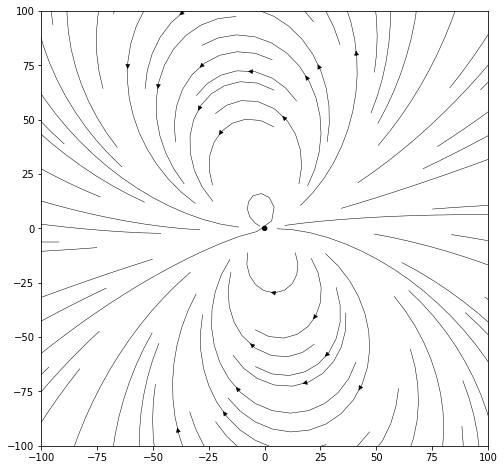

In [40]:
#b1,b2,b3 = compute_total_field(4.21*T/2/np.pi)
X,Z = np.meshgrid(xa,za)
fig=plt.figure(figsize=(8,8))
ax=fig.add_subplot(111)
circle=plt.Circle((0,0),1,color='k',fill=True)
ax.add_artist(circle)
ax.set_xlim(-100,100)
ax.set_ylim(-100,100)
ax.streamplot(X,Z,b1[:,center,:],b3[:,center,:],density=2,color='k',linewidth=0.5)
plt.show()

In [35]:
@jit(parallel=True)
def get_emission_point(t):
    thetas = np.linspace(0,np.pi,200)
    phis = np.linspace(0,2*np.pi,200)
    xsurf = np.zeros((len(thetas),len(phis))) 
    ysurf = np.zeros((len(thetas),len(phis)))
    zsurf = np.zeros((len(thetas),len(phis)))
    Bsurf = np.zeros((len(thetas),len(phis)))
    for i in range(len(thetas)):
        for j in range(len(phis)):
            xsurf[i][j] = r_em*np.sin(thetas[i])*np.cos(phis[j])
            ysurf[i][j] = r_em*np.sin(thetas[i])*np.sin(phis[j])
            zsurf[i][j] = r_em*np.cos(thetas[i])
            bx_s,by_s,bz_s = get_field(xsurf[i][j],ysurf[i][j],zsurf[i][j],t)
            if bz_s>0 and zsurf[i][j]>0:
                Bsurf[i][j] = bz_s    
    m = unravel_index(Bsurf.argmax(), Bsurf.shape)
    mx = m[0]
    my = m[1]
    xx = xsurf[mx][my]
    yy = ysurf[mx][my]
    zz = zsurf[mx][my]
    #print (Bsurf[mx][my])
    return xx,yy,zz

In [36]:
@jit(parallel=True)
def get_emission_point2(t,new_thetas,new_phis):
    xsurf2 = np.zeros((len(new_thetas),len(new_phis)))
    ysurf2 = np.zeros((len(new_thetas),len(new_phis)))
    zsurf2 = np.zeros((len(new_thetas),len(new_phis)))
    Bsurf2 = np.zeros((len(new_thetas),len(new_phis)))
    for i in range(len(new_thetas)):
        for j in range(len(new_phis)):
            xsurf2[i][j] = r_em*np.sin(new_thetas[i])*np.cos(new_phis[j])
            ysurf2[i][j] = r_em*np.sin(new_thetas[i])*np.sin(new_phis[j])
            zsurf2[i][j] = r_em*np.cos(new_thetas[i])      
            bx_s2,by_s2,bz_s2 = get_field(xsurf2[i][j],ysurf2[i][j],zsurf2[i][j],t)
            Bsurf2[i][j] = bz_s2
    m2 = unravel_index(Bsurf2.argmax(), Bsurf2.shape)
    mx2 = m2[0]
    my2 = m2[1]
    xx2 = xsurf2[mx2][my2]
    yy2 = ysurf2[mx2][my2]
    zz2 = zsurf2[mx2][my2]
    return xx2,yy2,zz2,Bsurf2[mx2][my2]

In [37]:
@jit(parallel=True)
def get_emission_point_final(t):
    p1,p2,p3 = get_emission_point(t)
    phi_p =  np.arctan2(p2,p1)*180/np.pi
    th_p = np.arccos(p3/np.sqrt(p1**2+p2**2+p3**2))*180/np.pi
    max_th_p, min_th_p = math.ceil(th_p),math.floor(th_p)
    max_phi_p, min_phi_p = math.ceil(phi_p),math.floor(phi_p)
    newth = np.linspace(-1+min_th_p,max_th_p+1,400)*np.pi/180
    newphi = np.linspace(-1+min_phi_p,max_phi_p+1,400)*np.pi/180
    #print (newphi*180/np.pi)
    nx,ny,nz,bz = get_emission_point2(t,newth,newphi)
    #print (nx,ny,nz)
    return nx,ny,nz,bz

In [38]:
#get_emission_point_final(0)
#get_emission_point((4.216)/omega)
#for i in range(20):
 #   get_emission_point_final((4.216+i)/omega)

In [39]:
#get_field(0.7325962577553875, 1.423371250680225, -7.838196030073489,4.216/omega)

In [40]:
def drawSphereMlab(center, radius, **kwargs):
    xc, yc, zc = center
    phi, theta = np.mgrid[0:np.pi:101j, 0:2*np.pi:101j]
    x = xc + radius * np.sin(phi) * np.cos(theta)
    y = yc + radius * np.sin(phi) * np.sin(theta)
    z = zc + radius * np.cos(phi)
    sphere = mlab.mesh(x, y, z, **kwargs)
    return sphere

In [41]:
@jit(parallel=True)
def cal_newbfield(xem,yem,zem,h,time):
    x_ray = xem
    y_ray = yem
    z_ray = zem + h
    B_x,B_y,B_z = get_field(x_ray,y_ray,z_ray,time)
    return B_x, B_y

In [42]:
t_ray = 1e6*1e3/3e10
xem,yem,zem = -0.5704200749348536, 4.215168445461376, 6.775468685965425
B_x, B_y = cal_newbfield(xem,yem,zem,1e6/1e6,0+t_ray)
print (B_x,B_y)

0.04052466212438885 -0.14519907775744262


/var/folders/4c/p1r_3jbn20jbtyp11b8_7y140001sh/T/ipykernel_23886/3889426500.py:6: NumbaPerformanceWarning: 
The keyword argument 'parallel=True' was specified but no transformation for parallel execution was possible.

To find out why, try turning on parallel diagnostics, see https://numba.pydata.org/numba-doc/latest/user/parallel.html#diagnostics for help.

File "../../../../var/folders/4c/p1r_3jbn20jbtyp11b8_7y140001sh/T/ipykernel_23886/2910317259.py", line 44:
<source missing, REPL/exec in use?>

  B_x,B_y,B_z = get_field(x_ray,y_ray,z_ray,time)
/Users/asur/myenv3/lib/python3.8/site-packages/numba/core/typed_passes.py:331: NumbaPerformanceWarning: 
The keyword argument 'parallel=True' was specified but no transformation for parallel execution was possible.

To find out why, try turning on parallel diagnostics, see https://numba.pydata.org/numba-doc/latest/user/parallel.html#diagnostics for help.

File "../../../../var/folders/4c/p1r_3jbn20jbtyp11b8_7y140001sh/T/ipykernel_23886/38894

In [43]:
@jit(parallel=True)
def cal_PA(h,T,color,lb):
    c = 3e10
    t_ray = h*1e3/c
    t = 0
    dt = 0.04
    Rl = c*T*1e-3/2/np.pi
    PA, phase = [],[]
    phi = 0
    while phi<2*np.pi:
        phi = omega*(t)
        #print (t, phi*180/np.pi)
        xem,yem,zem,bz = get_emission_point_final(t)
        B_x, B_y = cal_newbfield(xem,yem,zem,h/1e6,t+t_ray)
        print (phi,B_x,B_y)
        Psi = np.arctan(B_y/B_x)
        PA.append(Psi)
        phase.append(phi)
        t = t+dt
    PA = np.array(PA)*180/np.pi
    phase = np.array(phase)*180/np.pi
    #ax.scatter(phase,PA,s=20,c=color,alpha=0.8,label="r_em = "+str(lb/R)+"R")
    #ax.plot(phase,PA)
    return PA,phase

In [44]:
h = 1e5
PA,phase = cal_PA(h, T, 'gray',r_em)
#np.savetxt("PA_vacuum_rem%s_va%s.txt"%(str(r_em),str(75)),np.c_[phase,PA])

/var/folders/4c/p1r_3jbn20jbtyp11b8_7y140001sh/T/ipykernel_23886/1421225726.py:1: NumbaWarning: 
Compilation is falling back to object mode WITH looplifting enabled because Function "cal_PA" failed type inference due to: Invalid use of type(CPUDispatcher(<function get_emission_point_final at 0x15a24e0d0>)) with parameters (float64)

During: resolving callee type: type(CPUDispatcher(<function get_emission_point_final at 0x15a24e0d0>))
During: typing of call at /var/folders/4c/p1r_3jbn20jbtyp11b8_7y140001sh/T/ipykernel_23886/1421225726.py (13)


File "../../../../var/folders/4c/p1r_3jbn20jbtyp11b8_7y140001sh/T/ipykernel_23886/1421225726.py", line 13:
<source missing, REPL/exec in use?>

  @jit(parallel=True)
/Users/asur/myenv3/lib/python3.8/site-packages/numba/core/object_mode_passes.py:151: NumbaWarning: Function "cal_PA" was compiled in object mode without forceobj=True.

File "../../../../var/folders/4c/p1r_3jbn20jbtyp11b8_7y140001sh/T/ipykernel_23886/1421225726.py", line 1:
<source m

0.0 0.004335560466977899 -0.015578985636732483


/Users/asur/myenv3/lib/python3.8/site-packages/numba/core/typed_passes.py:331: NumbaPerformanceWarning: 
The keyword argument 'parallel=True' was specified but no transformation for parallel execution was possible.

To find out why, try turning on parallel diagnostics, see https://numba.pydata.org/numba-doc/latest/user/parallel.html#diagnostics for help.

File "../../../../var/folders/4c/p1r_3jbn20jbtyp11b8_7y140001sh/T/ipykernel_23886/1768417643.py", line 9:
<source missing, REPL/exec in use?>

  warnings.warn(errors.NumbaPerformanceWarning(msg,
/var/folders/4c/p1r_3jbn20jbtyp11b8_7y140001sh/T/ipykernel_23886/2145712759.py:1: NumbaWarning: 
Compilation is falling back to object mode WITH looplifting enabled because Function "get_emission_point2" failed type inference due to: Untyped global name 'unravel_index': Cannot determine Numba type of <class 'function'>

File "../../../../var/folders/4c/p1r_3jbn20jbtyp11b8_7y140001sh/T/ipykernel_23886/2145712759.py", line 14:
<source missing, R

0.06032823146595858 0.005132849989813868 -0.016168941398592266
0.12065646293191716 0.0059267035012933525 -0.016605030319561388
0.18098469439787573 0.00684620219979186 -0.01702761277326563
0.24131292586383432 0.007792897074237497 -0.017351085314029457
0.3016411573297929 0.008823776126538271 -0.01771807600616247
0.36196938879575147 0.009918715547589666 -0.018002222393983632
0.4222976202617101 0.011144179620325753 -0.018318511658821965
0.48262585172766864 0.012330962842935873 -0.018255543601781332
0.5429540831936271 0.013557306057528563 -0.018200838818611672
0.6032823146595857 0.014901772563363317 -0.018230577679411396
0.6636105461255443 0.016192748081701937 -0.017854888906273483
0.7239387775915028 0.017533780694181565 -0.01741994031425686
0.7842670090574614 0.018968752718944614 -0.01695577772475364
0.8445952405234199 0.02032004977476975 -0.016253773175677395
0.9049234719893786 0.021566672331498362 -0.015347470253222174
0.9652517034553373 0.022793859490446548 -0.014133652466414468
1.02557

/Users/asur/myenv3/lib/python3.8/site-packages/numba/core/typed_passes.py:331: NumbaPerformanceWarning: 
The keyword argument 'parallel=True' was specified but no transformation for parallel execution was possible.

To find out why, try turning on parallel diagnostics, see https://numba.pydata.org/numba-doc/latest/user/parallel.html#diagnostics for help.

File "../../../../var/folders/4c/p1r_3jbn20jbtyp11b8_7y140001sh/T/ipykernel_23886/2910317259.py", line 28:
<source missing, REPL/exec in use?>

  warnings.warn(errors.NumbaPerformanceWarning(msg,
/var/folders/4c/p1r_3jbn20jbtyp11b8_7y140001sh/T/ipykernel_23886/2910317259.py:15: NumbaWarning: 
Compilation is falling back to object mode WITH looplifting enabled because Function "cal_bfield" failed type inference due to: Untyped global name 'cal_m': Cannot determine Numba type of <class 'function'>

File "../../../../var/folders/4c/p1r_3jbn20jbtyp11b8_7y140001sh/T/ipykernel_23886/2910317259.py", line 20:
<source missing, REPL/exec in use

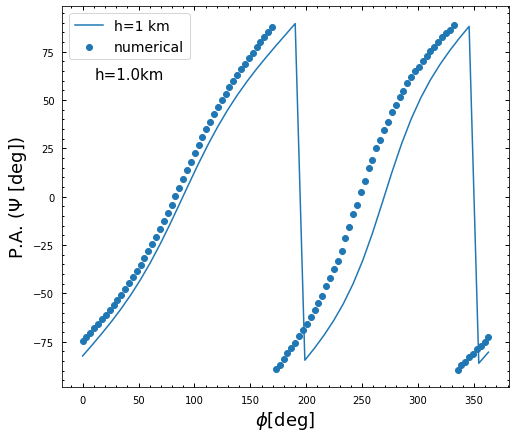

In [45]:
f = plt.figure(figsize=(8,7))
ax = f.add_subplot(111)
cal_PA_dip(h,r_em, T, ax)
ax.scatter(phase,PA,label="numerical")
ax.set_xlabel(r'$\phi$[deg]',size=18)
ax.set_ylabel(r'P.A. ($\Psi$ [deg])',size=18)
ax.legend(loc="best",fontsize=14,ncol=1)
ax.xaxis.set_minor_locator(AutoMinorLocator())
ax.yaxis.set_minor_locator(AutoMinorLocator())
ax.tick_params(axis="x", labelsize=18) 
ax.tick_params(axis="y", labelsize=18)
ax.text(10.5,60.8,"h="+str(h/1e5)+"km",size=15)
ax.tick_params(axis='both', which='major', direction='in',labelsize=10, length=4, width=1., colors='k', left=True, right=True, top=True, pad=8)
ax.tick_params(axis='both', which='minor', direction='in',labelsize=10, length=2, width=1, colors='k', left=True, right=True, top=True, pad=8)
plt.savefig("PA_vacuum.png",bbox_inches='tight')
plt.show()

In [46]:
np.savetxt('Ana_VC_47_8.txt',np.c_[phase,PA])

In [ ]:
f = plt.figure(figsize=(8,7))
ax = f.add_subplot(111)
ph1,pa1 = np.genfromtxt('PA_vacuum_rem1.2.txt',unpack=True)
ph2,pa2 = np.genfromtxt('PA_vacuum_rem2.0.txt',unpack=True)
ph3,pa3 = np.genfromtxt('PA_vacuum_rem4.0.txt',unpack=True)
ph4,pa4 = np.genfromtxt('PA_vacuum_rem8.0.txt',unpack=True)
ph5,pa5 = np.genfromtxt('PA_vacuum_rem16.0.txt',unpack=True)
ax.scatter(ph1,pa1,label="r_em=1.2R",s=20)
ax.scatter(ph2,pa2,label="r_em=2R",s=20)
ax.scatter(ph3,pa3,label="r_em=4R",s=20)
ax.scatter(ph4,pa4,label="r_em=8R",s=20)
ax.scatter(ph5,pa5,label="r_em=16R",s=20)
ax.set_xlabel(r'$\phi$[deg]',size=18)
ax.set_ylabel(r'P.A. ($\Psi$ [deg])',size=18)
ax.legend(loc="best",fontsize=14,ncol=1)
ax.xaxis.set_minor_locator(AutoMinorLocator())
ax.yaxis.set_minor_locator(AutoMinorLocator())
ax.tick_params(axis="x", labelsize=18) 
ax.tick_params(axis="y", labelsize=18)
ax.tick_params(axis='both', which='major', direction='in',labelsize=10, length=4, width=1., colors='k', left=True, right=True, top=True, pad=8)
ax.tick_params(axis='both', which='minor', direction='in',labelsize=10, length=2, width=1, colors='k', left=True, right=True, top=True, pad=8)
plt.savefig("PA_vacuum_rem.png",bbox_inches='tight')
plt.show()

In [ ]:
f = plt.figure(figsize=(8,7))
ax = f.add_subplot(111)
#ph1,pa1 = np.genfromtxt('PA_vacuum_rem2.0_va40.txt',unpack=True)
ph2,pa2 = np.genfromtxt('PA_vacuum_rem2.0_va45.txt',unpack=True)
ph3,pa3 = np.genfromtxt('PA_vacuum_rem2.0_va54.txt',unpack=True)
#ph4,pa4 = np.genfromtxt('PA_vacuum_rem2.0_va60.txt',unpack=True)
ph5,pa5 = np.genfromtxt('PA_vacuum_rem2.0_va65.txt',unpack=True)
#ph6,pa6 = np.genfromtxt('PA_vacuum_rem2.0_va70.txt',unpack=True)
ph7,pa7 = np.genfromtxt('PA_vacuum_rem2.0_va75.txt',unpack=True)
#ax.scatter(ph1,pa1,label="delta=40")
ax.scatter(ph2,pa2,label="OA=35")
ax.scatter(ph3,pa3,label="OA=26")
#ax.scatter(ph4,pa4,label="delta=60")
ax.scatter(ph5,pa5,label="OA=15")
#ax.scatter(ph6,pa6,label="delta=60")
ax.scatter(ph7,pa7,label="OA=5")
ax.set_xlabel(r'$\phi$[deg]',size=18)
ax.set_ylabel(r'P.A. ($\Psi$ [deg])',size=18)
ax.legend(loc="best",fontsize=14,ncol=1)
ax.xaxis.set_minor_locator(AutoMinorLocator())
ax.yaxis.set_minor_locator(AutoMinorLocator())
ax.tick_params(axis="x", labelsize=18) 
ax.tick_params(axis="y", labelsize=18)
ax.tick_params(axis='both', which='major', direction='in',labelsize=10, length=4, width=1., colors='k', left=True, right=True, top=True, pad=8)
ax.tick_params(axis='both', which='minor', direction='in',labelsize=10, length=2, width=1, colors='k', left=True, right=True, top=True, pad=8)
plt.savefig("PA_vacuum_va.png",bbox_inches='tight')
plt.show()

In [6]:
def drawSphereMlab(center, radius, **kwargs):
    xc, yc, zc = center
    phi, theta = np.mgrid[0:np.pi:101j, 0:2*np.pi:101j]
    x = xc + radius * np.sin(phi) * np.cos(theta)
    y = yc + radius * np.sin(phi) * np.sin(theta)
    z = zc + radius * np.cos(phi)
    sphere = mlab.mesh(x, y, z, **kwargs)
    return sphere

In [15]:
from scipy.interpolate import RegularGridInterpolator
datadir='.'
data=Data(datadir)
conf = data._conf
data_bx = np.transpose(data.Bx,(0,1,2))
data_by = np.transpose(data.By,(0,1,2))
data_bz = np.transpose(data.Bz,(0,1,2))

t = 0
phi=0
dt = 0.1
while phi<6.28*np.pi:
    phi = omega*(t)
    b1,b2,b3 = compute_total_field(t)
    b1 = np.transpose(b1)
    b2 = np.transpose(b2)
    b3 = np.transpose(b3)
    fig = mlab.figure(1, size=(800, 800), bgcolor=(1, 1, 1), fgcolor=(0, 0, 0))
    field = mlab.pipeline.vector_field(b1, b2, b3)  
    magnitude = mlab.pipeline.extract_vector_norm(field)
    field_lines = mlab.pipeline.streamline(magnitude, seedtype='sphere',
                                       integration_direction='both',colormap='binary')
    drawSphereMlab((center,center,center), 2, color=(0,0,1))
    field_lines.stream_tracer.maximum_propagation = 100.
    field_lines.seed.widget.enabled = False
    mlab.view(azimuth=10, elevation=20, distance=60)
    mlab.savefig(filename="%s.png"%str(t))
    t+=1
    mlab.show()
    #mlab.close()

qt.qpa.window: <QNSWindow: 0x7fe15ad51eb0; contentView=<QNSView: 0x7fe15ad51770; QCocoaWindow(0x7fe15ad51660, window=QWidgetWindow(0x7fe15ad511b0, name="QMainWindowClassWindow"))>> has active key-value observers (KVO)! These will stop working now that the window is recreated, and will result in exceptions when the observers are removed. Break in QCocoaWindow::recreateWindowIfNeeded to debug.
qt.qpa.window: <QNSWindow: 0x7fe11f644210; contentView=<QNSView: 0x7fe11f643ae0; QCocoaWindow(0x7fe11f6439d0, window=QWidgetWindow(0x7fe11f643520, name="QMainWindowClassWindow"))>> has active key-value observers (KVO)! These will stop working now that the window is recreated, and will result in exceptions when the observers are removed. Break in QCocoaWindow::recreateWindowIfNeeded to debug.
qt.qpa.window: <QNSWindow: 0x7fe14556efc0; contentView=<QNSView: 0x7fe14556e890; QCocoaWindow(0x7fe14556e780, window=QWidgetWindow(0x7fe14556e2d0, name="QMainWindowClassWindow"))>> has active key-value observer